In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dt
import os
from os import path
import h5py
import re
from datetime import datetime
import requests

In [2]:
'''
Initialize variables
'''

#It can be left blank if the txt file is in the same path as the script
UNR_SITE_LIST_FILE = ''
folder_name = 'data'

lat = round(19.479)
lon = round(-155.602)

start_date = '2000-01-07'
end_date = '2011-01-07'

In [3]:
def dload_site_list_hdf5(folder, path):
    '''
    Creates data folder
    '''
    if not folder:
        folder = 'data'
    
    if not os.path.exists(folder):
        os.mkdir(folder)

    '''
    Looks for list of links i.e. the only txt file in the current folder
    '''
    if not path:
    
        txt_files = [f for f in os.listdir('.') if f.endswith('.txt')]

        if len(txt_files) != 1:
            raise ValueError('should be only one txt file in the current directory')

        path = txt_files[0]

    '''
    Loop torough every line in the list of links .txt file and download every .HDF5 file within the list
    '''

    with open(path, "r") as ifile:
            for URL in ifile:
                if '.HDF5' in URL[-6:]:

                    d = re.search('\d{8}', URL)
                    d.group(0)
                    date = datetime.strptime(d.group(0), "%Y%d%m").date()

                    FILENAME = folder + '/'+ str(date) + '.HDF5'

                    if not os.path.exists(FILENAME):

                        result = requests.get(URL.strip())

                        try:
                            result.raise_for_status()
                            f = open(FILENAME,'wb')
                            f.write(result.content)
                            f.close()
                            print('contents of URL written to '+FILENAME)
                        except:
                            print('requests.get() returned an error code '+str(result.status_code))

                    else:
                        print(f'File: {FILENAME} already exists')
    return folder

In [4]:
def adapt_coordinates(lon, lat):

    if -179.95 <= lon <= 179.95:

        val = 0.5 if lon > 0 else  -0.5
        lon = lon*10 + val
        
    else:
        raise ValueError(f'Values not in the Interval (-179.5, 179.5)')
        
    if -89.95 <= lat <= 89.95:

        val = 0.5 if lat > 0 else -0.5
        lat = lat*10 + val

    else:
        raise ValueError(f'Values not in the Interval (-89.95, 89.95)')
        
    return lon, lat

In [5]:
def plot_precipitaion(longitude, latitude, start_date, end_date, folder, path):
        
        newdf = {}
        df = pd.DataFrame()
        dictionary = {}
    
        longitude, latitude = adapt_coordinates(longitude, latitude)

        sdate = datetime.strptime(start_date,'%Y-%d-%m')
        edate = datetime.strptime(end_date,'%Y-%d-%m')

        '''
        Loops trough every HDF5 file
        '''
        for f in os.listdir(folder):

            if f.endswith('.HDF5'):

                file = './' + folder + '/'+ f

                try:
                    
                    data = h5py.File(file,'r')
                    
                except:
                    
                    folder = dload_site_list_hdf5(folder, path)

                d = re.search('\d{4}[-]\d{2}[-]\d{2}', file)
        #       date = datetime.strptime(d.group(0),'%Y-01-%m')
                date = datetime.strptime(d.group(0), "%Y-%d-%m").date()
                
                date_list = pd.date_range(start = sdate,end = edate).date

                if date in date_list:

                    dictionary[str(date)] = {}

                    lon = np.arange(-1799.5, 1800.5, 1)
                    lat = np.arange(-899.5,900.5,1)

                    for key in data.keys():        
                        pre = data[key]['precipitation']
                        lonPrec = dict(zip(lon, zip(*pre)))

                    lonPrec[longitude]

                    i = list(lat).index(latitude)
                    dictionary[str(date)] = lonPrec[longitude][0][i]

                    df1 = pd.DataFrame(dictionary.items(), columns=['Date', 'Precipitation'])
                    newdf = pd.concat([df,df1], ignore_index=True, sort=False)

                else: continue
                    
        return newdf  

In [6]:
newdf = plot_precipitaion(lon, lat, start_date, end_date, folder_name, '') 
newdf

,Date,Precipitation
0,2000-07-01,0.009906
1,2000-08-01,0.004815
2,2000-09-01,0.001686
3,2000-10-01,0.006147
4,2000-11-01,0.127815
...,...,...
128,2011-03-01,0.057718
129,2011-04-01,0.024232
130,2011-05-01,0.008736
131,2011-06-01,0.006081


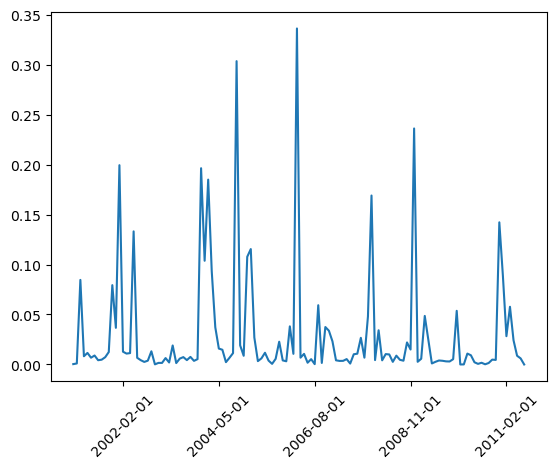

In [22]:
# newdf["roll30"] = newdf.Precipitation.rolling(30).sum()
# newdf["roll90"] = newdf.Precipitation.rolling(90).sum()
# newdf["roll180"] = newdf.Precipitation.rolling(180).sum()

# newdf["log30"] = np.log(newdf.roll30)
# newdf["log90"] = np.log(newdf.roll90)
# newdf["log180"] = np.log(newdf.roll180)
# newdf['norm']=(newdf.Precipitation-newdf.Precipitation.min())/(newdf.Precipitation.max()-newdf.Precipitation.min())

newdf["cum"] = newdf.Precipitation.cumsum()


rainfalldfNoNull =newdf.dropna()

# plt.plot(newdf.Date,newdf.Precipitation)

plt.plot(rainfalldfNoNull.Date, rainfalldfNoNull.Precipitation)

#Calculate intervals base on Dataframe dimension
interval = round((newdf.shape[0]/100)*20)

#Invervals for x axes label
plt.gca().xaxis.set_major_locator(dt.DayLocator(interval=interval))

plt.xticks(rotation=45)

# Data plot
plt.show()

In [29]:
'''
Example of global precipitations given by Nasa at: https://gpm.nasa.gov/data/tutorials
'''

data = h5py.File(file,'r')
precip = data['/Grid/precipitation'][:]
precip = np.flip( precip[0,:,:].transpose(), axis=0 )
plt.imshow( precip, vmin=-1, vmax=2, extent=[-180,180,-90,90] )

# -- add a color bar
cbar = plt.colorbar( )
cbar.set_label('millimeters/hour')

# -- display lat/lon grid lines
for lon in np.arange(-90,90+1,90):
  dummy = plt.plot( (lon,lon), (-90,+90), color="black", linewidth=1 )

for lat in np.arange(-60,60+1,30):
  dummy = plt.plot( (-180,+180), (lat,lat), color="black", linewidth=1 )

NameError: name 'file' is not defined